 # Using Word Embeddings for Data Augmentation

In [0]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip -O temp.zip; unzip temp.zip; rm temp.zip

--2019-01-23 18:08:43--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2019-01-23 18:08:43--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘temp.zip’

temp.zip            100%[===================>]   2.03G  36.4MB/s    in 36s     

2019-01-23 18:09:20 (57.3 MB/s) - ‘temp.zip’ saved [2176768927/2176768927]

Archive:  temp.zip
  inflating: glove.840B.300d.txt     


In [0]:
%%capture
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

np.random.seed(100)
import nltk
nltk.download('popular')

## Step 1 : Loading Word Embeddings

In [0]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def load_embedding(file):
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [0]:
def make_embedding_matrix(embedding, tokenizer, len_voc):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = tokenizer.word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [0]:
glove = load_embedding('glove.840B.300d.txt')

I'm using GloVe, because that's the embedding I got the best results with inbefore, but paragram is quite good as well.

## Step 2 : Loading Data

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1DnWHFdfNYEpvegCNNPzCWpNXUuK9t7FC',     # Id of file to be downloaded
                                    dest_path='data/offenseval-training-v1.tsv')     # Destination path

In [0]:
import pandas as pd
df = pd.read_table("data/offenseval-training-v1.tsv",sep='\t',index_col=False, error_bad_lines=False) 
df = df.loc[df['subtask_a'] == 'OFF']
df = df.drop(['subtask_a','subtask_c'],axis=1)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['subtask_b'])
df=X_train

In [0]:
len(list(df['tweet'].str.split(' ', expand=True).stack().unique()))

15945

In [0]:
df.head(10)

,id,tweet,subtask_b
6974,80728,@USER Anyone else think she is a lying opportu...,TIN
4883,60283,@USER @USER I love women like you. We believe ...,TIN
5319,42541,@USER It’s a disgrace and @USER are in danger ...,TIN
3712,40736,@USER But I thought California had gun control,TIN
10228,31646,@USER Mon « bye bitches » suffisait,TIN
6372,43865,@USER @USER @USER @USER @USER @USER @USER @USE...,TIN
2640,53665,@USER @USER And not all idiots grandstands lik...,TIN
7020,98387,@USER Conservatives; the trailer trash party o...,TIN
4020,99173,@USER @USER Says the bitch ass boy hiding behi...,TIN
5588,47922,@USER Bad gun control seems like. Missed his b...,TIN


In [0]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords

from scipy.stats import itemfreq
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,HashingVectorizer
from sklearn.metrics import confusion_matrix

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()  
  
pd.options.mode.chained_assignment = None

def clean_text(content):
  content=content.str.replace('@USER','')                                     # Remove triggerword tags
  content=content.str.lower()                                                         # Convert to Lowercase
  content=content.str.replace('username','')                                          # Remove username tags
  content=content.str.replace('http\S+|www.\S+', '')                                  # Remove Links
  content=content.str.replace('\s+', ' ')                                             # Remove multiple spaces
  content=content.str.replace('[^A-Za-z\s]+', '')                                     # Remove irrelevant characters other than alphabets and space
  #content=content.apply(lemmatize_sentences)
  return content

In [0]:
df['tweet'] = clean_text(df['tweet'])
X_test['tweet'] = clean_text(X_test['tweet'])

In [0]:
df.head(10)

,id,tweet,subtask_b
6974,80728,anyone else think she is a lying opportunist ...,TIN
4883,60283,i love women like you we believe all women ex...,TIN
5319,42541,its a disgrace and are in danger of imploding...,TIN
3712,40736,but i thought california had gun control,TIN
10228,31646,mon bye bitches suffisait,TIN
6372,43865,you mean like all the liberals screaming at a...,TIN
2640,53665,and not all idiots grandstands like he did,TIN
7020,98387,conservatives the trailer trash party of canada,TIN
4020,99173,says the bitch ass boy hiding behind a keyboa...,TIN
5588,47922,bad gun control seems like missed his brains ...,TIN


### Class imbalance

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


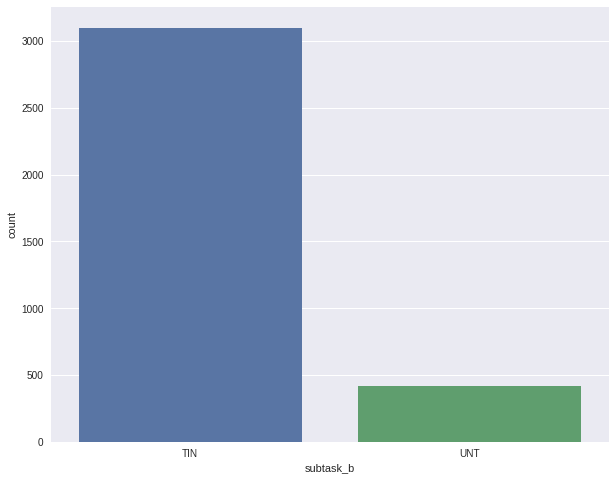

In [0]:
plt.figure(figsize = (10, 8))
sns.countplot(df['subtask_b'])
plt.show()

In [0]:
print("Class repartition : ", (Counter(df['subtask_b'])))

Class repartition :  Counter({'TIN': 3101, 'UNT': 419})


There is way more 0s than 1s in our dataset. As mentionned, we could use data augmentation to balance classes. Therefore the prediction task will be easier.

## Step 3: Tokenizing

I am using Keras' Tokenizer to apply some text processing and to limit the size of the vocabulary

In [0]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

# Get the stop words defined in nltk for english
stop_words = set(stopwords.words('english'))                             

# Create filtered & tagged sentences as list
filtered_sentences=[]                                                                                   

for index, row in df.iterrows():
        # Tokenize each line
        word_tokens = word_tokenize(row['tweet'])   
        #word_tokens = [x.lower() for x in word_tokens]
        # Filter the tokens without stop words and put them in a list
        sentence = [w for w in word_tokens]
        # Append the sentence(a list) to filtered sentences
        filtered_sentences.append(sentence)                              

In [0]:
# Train a word2vec model 

from gensim.models import Word2Vec
model=Word2Vec(filtered_sentences,size=100, window=10,min_count=5)              # Define a word2vec model
model.train(filtered_sentences,total_examples=len(filtered_sentences),epochs=3) # Train the model for 3 epochs
model.save("word2vec.model")                                                    # Save the model

In [0]:
word_dict = {}
for line in filtered_sentences:
  for word in line:
    if(word in model.wv.vocab):
      word_dict[word]= model.wv.most_similar(positive = word,topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Step 4 - Data Augmentation / Oversampling 

#### We work on 1 labelled texts. We apply the following algorithm to modify a sentence :

For each word in the sentence :
* Keep it with probability $p$  (or if we don't have synonyms for it)
* Randomly swap it with one of its synonyms with probability $1-p$

In [0]:
unt_data = df[df['subtask_b'] == 'UNT']

In [0]:
X_unt = []
for index, row in unt_data.iterrows():
        # Tokenize each line
        word_tokens = word_tokenize(row['tweet'])   
        #word_tokens = [x.lower() for x in word_tokens]
        # Filter the tokens without stop words and put them in a list
        sentence = [w for w in word_tokens]
        # Append the sentence(a list) to filtered sentences
        X_unt.append(sentence)                              

In [0]:
len(X_unt)

419

In [0]:
def modify_sentence(sentence, word_dict, p=0.9):
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = word_dict[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence

### Let us preview our function

In [0]:
indexes = np.random.randint(0, len(X_unt), 10)

In [0]:
for x in X_unt[indexes]:
    print(x)

    modified = modify_sentence(x, synonyms)
    print(modified)
    
    print(' ')

Looks pretty good, we now generate some texts

In [0]:
n_texts = 2700

In [0]:
indexes = np.random.randint(0, X_pos.shape[0], n_texts)

In [0]:
X_gen = np.array([modify_sentence(x, synonyms) for x in X_pos[indexes]])
y_gen = np.ones(n_texts)

In [0]:
def get_sentence(modified):
  return ' '.join([index_word[x] for x in modified])

In [0]:
X_new = np.concatenate((X_pos, X_gen), axis=0)
X_add = pd.DataFrame({"tweet":np.apply_along_axis(get_sentence, 1, X_new)})

In [0]:
X_add["subtask_b"] = "UNT"

In [0]:
X_add.tweet = X_add.tweet.str.strip()

In [0]:
X_tin = df[df['subtask_b']=='TIN']
X_tin = X_tin.drop(['id'],axis=1)

In [0]:
new_data = pd.concat([X_tin,X_add],axis=0)
new_data.to_csv('new_train_data.tsv',sep='\t',index=False)

In [0]:
X_test = X_test.drop('id',axis=1)
X_test.head(10)

,tweet,subtask_b
6570,when the abuser projects look in the mirror m...,TIN
4699,maga white people,TIN
7630,when is this low iq piece of human trash goin...,TIN
3108,holder has a perverted view of the law not su...,TIN
5654,this soros guy needs to be investigated hes b...,TIN
7778,w had empathy and regrets he may have been a ...,TIN
2160,whats wrong with dead antifa i dont understan...,TIN
3728,i hate so much now they fucked up the whole f...,TIN
9371,hatred of the man makes people like this fool...,UNT
9620,i think we should be going after sen feinstei...,TIN


In [0]:
X_test.to_csv('new_dev_data.tsv',sep='\t',index=False)

In [0]:
from google.colab import files
files.download('new_train_data.tsv')
files.download('new_dev_data.tsv')